<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/Encoder_logistic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4008, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 4008 (delta 129), reused 185 (delta 56), pack-reused 3722
Receiving objects: 100% (4008/4008), 680.84 MiB | 31.73 MiB/s, done.
Resolving deltas: 100% (714/714), done.
Checking out files: 100% (2856/2856), done.
/content/STAT3007_Project


In [2]:
pip install colorednoise

  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp37-none-any.whl size=3958 sha256=0db720345d8deb189a15ccb445790eba5d85bbc92784aec54b1bcb99f9e20dfb
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built colorednoise


In [3]:
import librosa
from librosa import display
import colorednoise as cn
import torch
import numpy as np
from IPython.display import Audio
import glob
from pre_process import *
from data_loading import *
import os
import torch.optim as optim
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor

import scipy
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import numpy as np


configure the device

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device == torch.device('cuda'))

True


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load the spectrogram data, 40 snr

In [6]:
train_noisy_spectrogram = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_train_snr40.npy')
train_clean_spectrogram = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/clean_train_snr40.npy')
test_noisy_spectrogram = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_test_snr40.npy')
test_clean_spectrogram = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/clean_test_snr40.npy')
test_noisy_target = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_test_snr40.npy')

In [7]:
train_noisy_spectrogram = train_noisy_spectrogram.reshape(train_noisy_spectrogram.shape[0],1,train_noisy_spectrogram.shape[1],train_noisy_spectrogram.shape[2])
train_clean_spectrogram = train_clean_spectrogram.reshape(train_clean_spectrogram.shape[0],1,train_clean_spectrogram.shape[1],train_clean_spectrogram.shape[2])
test_noisy_spectrogram = test_noisy_spectrogram.reshape(test_noisy_spectrogram.shape[0],1,test_noisy_spectrogram.shape[1],test_noisy_spectrogram.shape[2])
test_clean_spectrogram = test_clean_spectrogram.reshape(test_clean_spectrogram.shape[0],1,test_clean_spectrogram.shape[1],test_clean_spectrogram.shape[2])


In [8]:
print(train_noisy_spectrogram.shape)
print(train_clean_spectrogram.shape)
print(test_noisy_spectrogram.shape)
print(test_clean_spectrogram.shape)

(6880, 1, 128, 63)
(6880, 1, 128, 63)
(3440, 1, 128, 63)
(3440, 1, 128, 63)


In [9]:
denoise_train = DatasetWrapper(torch.tensor(train_noisy_spectrogram), torch.tensor(train_clean_spectrogram))
denoise_test = DatasetWrapper(torch.tensor(test_noisy_spectrogram), torch.tensor(test_clean_spectrogram))

# Network Architecture

In [ ]:
# Autoencoder with optimal hyper-parameters already put in
class Encoder(nn.Module):
  def __init__(self, filters = 8, kernal_size = (3,4)):
    super(Encoder, self).__init__()
    (K, S) = (5, 1)
    self.conv = nn.Sequential(nn.Conv2d(1, filters, kernel_size= kernal_size, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.ReLU(),
                              nn.Conv2d(filters,filters,kernel_size= kernal_size, stride = 1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size = 2),
                              nn.Conv2d(filters,filters,kernel_size= kernal_size, stride = 1),
                              nn.ReLU()
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x


class Decoder(nn.Module):
  def __init__(self, filters = 8, kernal_size = (3,4), upsample_size1=(61,27), upsample_size2=(126,60)):
    super(Decoder, self).__init__()
    (K, S) = (2, 1)
    self.conv = nn.Sequential(nn.ConvTranspose2d(filters,filters, kernel_size = kernal_size),
                              nn.ReLU(),
                              nn.Upsample(size = upsample_size1),
                              nn.ConvTranspose2d(filters,filters, kernel_size = kernal_size),
                              nn.ReLU(),
                              nn.Upsample(size = upsample_size2),
                              nn.ConvTranspose2d(filters,1, kernel_size = kernal_size),
                              )
    
  def forward(self, x):
    x = self.conv(x)
    return x

class Autoencoder(nn.Module):
  def __init__(self, filters, kernal_size=(3,4), upsample_size1=(61,27), upsample_size2=(126,60)):
    super(Autoencoder,self).__init__()
    self.filters = filters
    self.kernal_size = kernal_size
    self.upsample_size1 = upsample_size1
    self.upsample_size2 = upsample_size2
    self.encoder = Encoder(filters, kernal_size)
    self.decoder = Decoder(filters, kernal_size, upsample_size1, upsample_size2)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

# Save state_dict()

In [15]:
state_save_path = '/content/drive/MyDrive/STAT3007_project/denoised_saved_model_parameters'
#torch.save(net.state_dict(), state_save_path)

In [16]:
model = Autoencoder(8, (4,2), (59,30),(125,62))
model.load_state_dict(torch.load(state_save_path))

<All keys matched successfully>

<class '__main__.Autoencoder'>


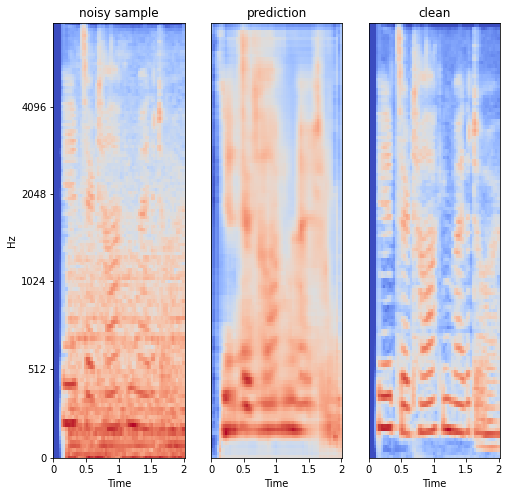

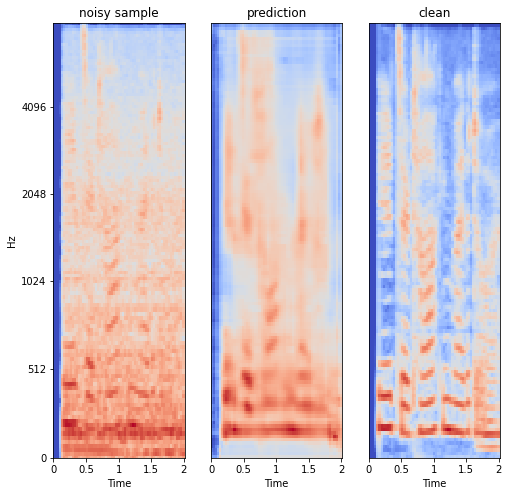

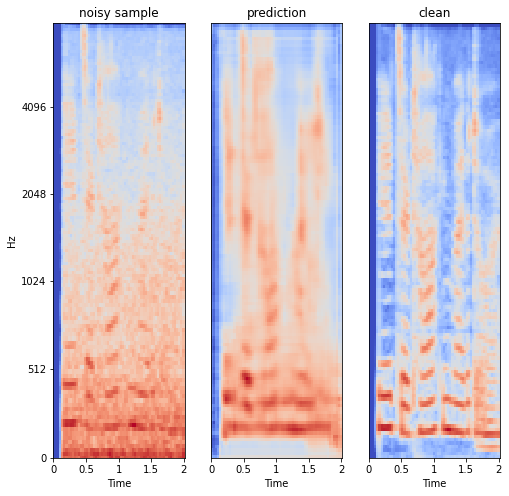

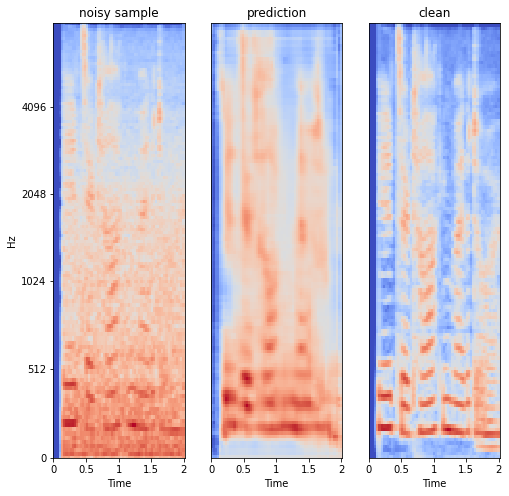

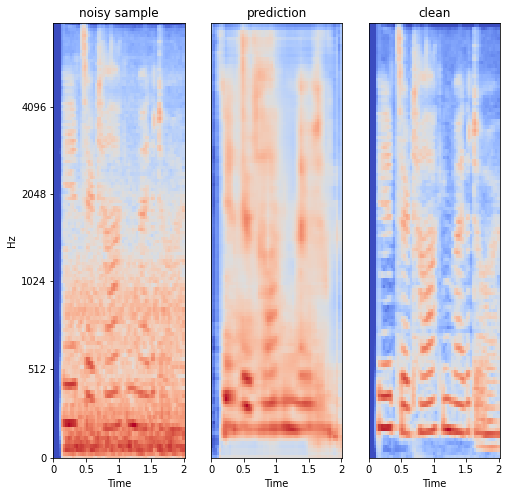

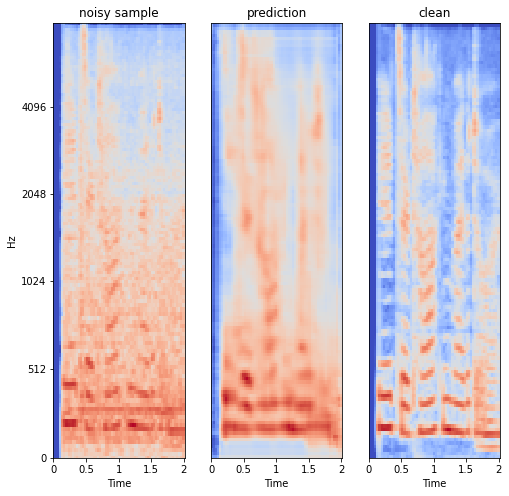

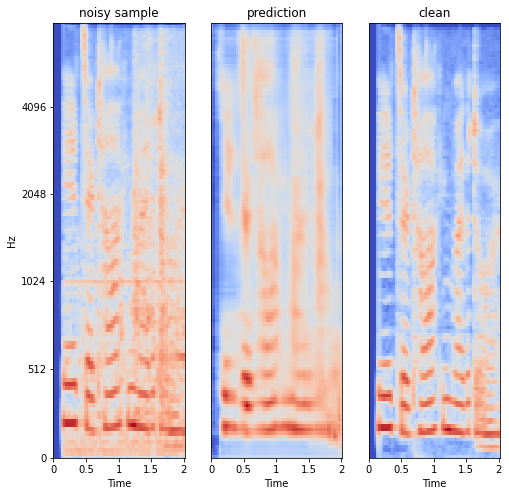

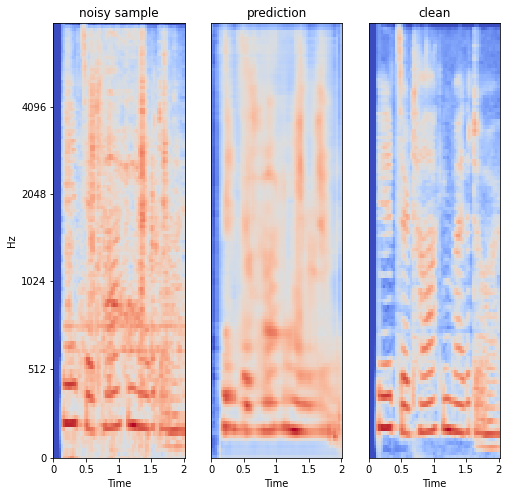

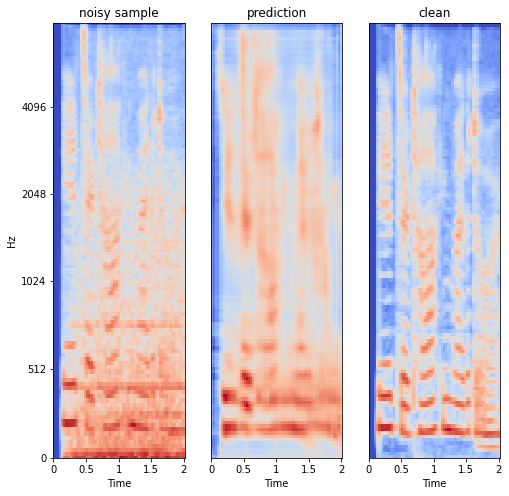

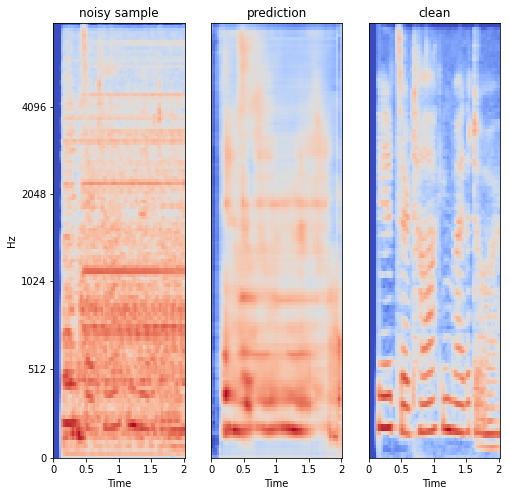

In [17]:
X_test, y_test = denoise_test.get_data()
X_test = X_test.type(torch.FloatTensor).to(torch.device('cpu'))
if (device == torch.device('cuda')):
    model = model.to(torch.device('cpu'))
print(type(model))
y_pred = model(X_test)

for i in range(10):
    plt.figure(figsize = (8,8))
    plt.subplot2grid((1,3),(0,0))
    librosa.display.specshow(X_test[i,0].detach().numpy(), y_axis='mel', fmax=8000, x_axis='time', sr =16000);
    plt.title('noisy sample')

    plt.subplot2grid((1,3),(0,1))
    librosa.display.specshow(y_pred[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('prediction')


    ax = plt.subplot2grid((1,3),(0,2))
    librosa.display.specshow(y_test[i,0].detach().numpy(), fmax=8000, x_axis='time', sr =16000);
    plt.title('clean')
    plt.show()

In [21]:
model.encoder

Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 2), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(8, 8, kernel_size=(4, 2), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(8, 8, kernel_size=(4, 2), stride=(1, 1))
    (8): ReLU()
  )
)

In [28]:
encoder = model.encoder

In [30]:
X_feature = encoder(torch.tensor(test_noisy_spectrogram))
y = torch.tensor(test_noisy_target)

In [31]:
X_feature = X_feature.detach()

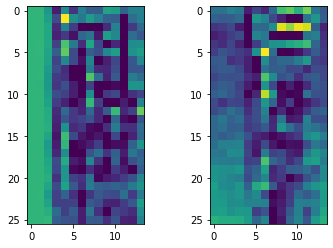

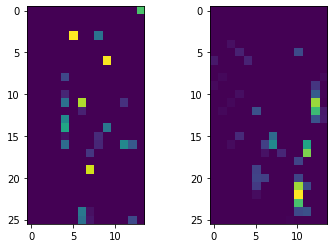

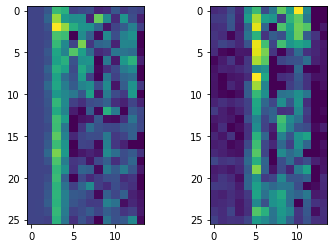

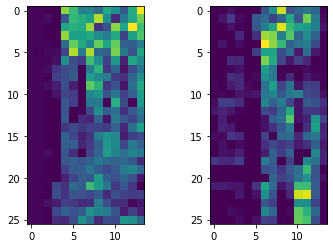

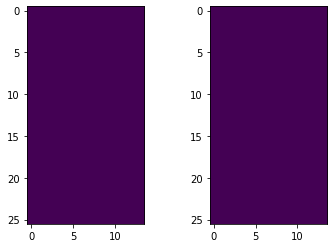

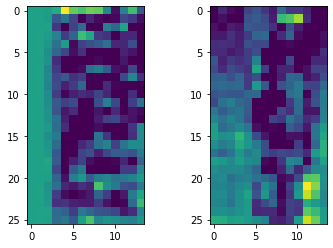

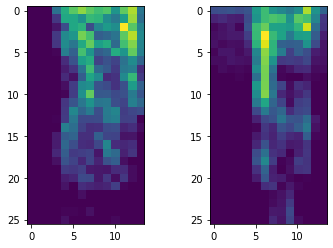

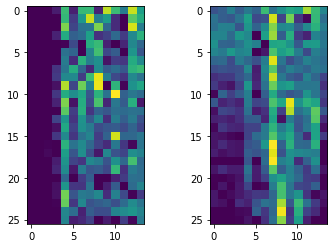

In [56]:
a = np.random.random(2)

a = (a * 3440)//1

for i in range(8):
  plt.figure()
  plt.subplot(121)
  plt.imshow(X_feature[int(a[0])][i])
  plt.subplot(122)
  plt.imshow(X_feature[int(a[1])][i])

In [37]:
X_feature_flat = torch.flatten(X_feature,start_dim = 1)
X_train, X_test, y_train, y_test = train_test_split(X_feature_flat, y, test_size=0.3, random_state=42)

In [38]:

# building a naive bayes classifier
def classification_model(X_train,y_train, X_test, y_test):
  NB = MultinomialNB()
  NB.fit(X_train,y_train)
  y_pred = NB.predict(X_test)

  # metrics
  # count correctly classified samples
  correct_count = np.count_nonzero(y_pred == y_test)
  accuracy = metrics.accuracy_score(y_test,y_pred)
  balanced_accuracy = metrics.balanced_accuracy_score(y_test,y_pred)

  print('total sample counts:',y_pred.shape[0])
  print('correct classification counts:',correct_count,'(',accuracy * 100,'%)')
  print('{0}: {1:.1%}'.format('balanced accuracy', balanced_accuracy))
  print('misclasification counts:',y_pred.shape[0] - correct_count,'(',(1 - accuracy)*100,'%)')

  return NB

In [62]:
y_train.shape

torch.Size([2408])

In [65]:
for i in range(5):
  print(np.where(y_train == i)[0].shape)

(485,)
(481,)
(455,)
(480,)
(507,)


In [66]:
NB = classification_model(X_train.detach().numpy(),y_train.detach().numpy(), X_test.detach().numpy(), y_test.detach().numpy())

total sample counts: 1032
correct classification counts: 872 ( 84.49612403100775 %)
balanced accuracy: 84.7%
misclasification counts: 160 ( 15.503875968992254 %)


In [67]:
y_pred = NB.predict(X_test)

In [72]:
y_pred

array([3, 0, 2, ..., 3, 4, 1])

In [78]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test.detach().numpy(), y_pred)
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)

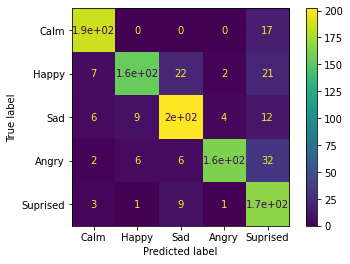

In [79]:
thing.plot()